The discrete Fourier transform acts on a vector $(x_0, ..., x_{N-1})$ and maps it to the vector $(y_0, ..., y_{N-1})$ according to the formula


$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$


where $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$.

Similarly, the quantum Fourier transform acts on a quantum state $\sum_{i=0}^{N-1} x_i \vert i \rangle$ and maps it to the quantum state $\sum_{i=0}^{N-1} y_i \vert i \rangle$ according to the formula


$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$


with $\omega_N^{jk}$ defined as above. Note that only the amplitudes of the state were affected by this transformation.

This can also be expressed as the map:


$$\vert x \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle$$



Or the unitary matrix:


$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} \omega_N^{xy} \vert y \rangle \langle x \vert$$



In the computational basis, we store numbers in binary using the states $\vert 0\rangle$ and $\vert 1\rangle$

![](https://qiskit.org/textbook/ch-algorithms/images/zbasis-counting.gif "computational basis counting")

In fourier basis, we store numbers using different rotations around the z-axis:

![](https://qiskit.org/textbook/ch-algorithms/images/fourierbasis-counting.gif "fourier basis counting")

The QFT transforms between the computational (Z) and the fourier basis

$$
|\text{State in Computational Basis}\rangle \quad \xrightarrow[]{\text{QFT}} \quad |\text{State in Fourier Basis}\rangle
$$

$$
\text{QFT}|x\rangle = |\widetilde{x}\rangle
$$

Where the states in fourier basis are denoted with tilde (~)

In [26]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

plt.style.use('seaborn-poster')
%matplotlib inline

In [27]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [28]:
#Parameters:
CIRCUIT_SIZE = 10

In [29]:
qc = QuantumCircuit(CIRCUIT_SIZE)
qft(qc,CIRCUIT_SIZE)
# qc.draw()

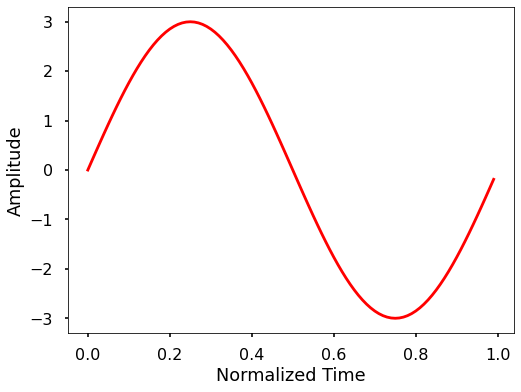

In [37]:
# sampling rate
sr = 100
# sampling interval
ts = 1.0/sr
t = np.arange(0,1,ts)

freq = 1.
x = 3*np.sin(2*np.pi*freq*t)

plt.figure(figsize = (8, 6))
plt.plot(t, x, 'r')
plt.ylabel('Amplitude')
plt.xlabel('Normalized Time')

plt.show()

In [33]:
def DFT(x):
    """
    Function to calculate the 
    discrete Fourier Transform 
    of a 1D real-valued signal x
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

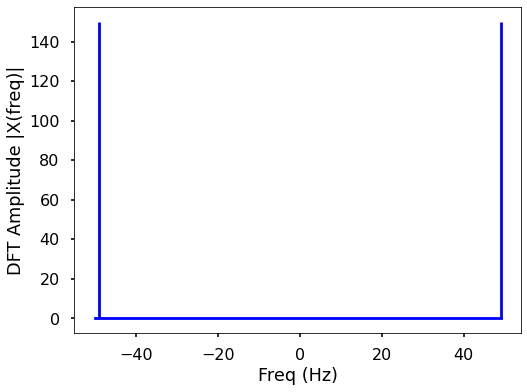

In [35]:
X = DFT(x)

# calculate the frequency
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

plt.figure(figsize = (8, 6))
plt.stem(freq, abs(X), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Freq (Hz)')
plt.ylabel('DFT Amplitude |X(freq)|')
plt.show()